<a href="https://colab.research.google.com/github/s-mishra/statrethinking_lectures_numpyro/blob/main/week5/iwona_rethinking_week_5_chapter_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Useful links:

* [HOMEWORK](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework)

* [Book code translated into NumPyro](https://fehiepsi.github.io/rethinking-numpyro/)

* [Book and homework code in Python/PyMC3](https://github.com/pymc-devs/resources/tree/master/Rethinking_2)

* [NumPyro documentation](http://num.pyro.ai/en/stable/api.html)

* [NumPyro examples](http://num.pyro.ai/en/latest/index.html#introductory-tutorials)

* [Other languagaes and videos](https://github.com/rmcelreath/stat_rethinking_2020)

In [1]:
!pip install numpyro


     |████████████████████████████████| 264 kB 4.3 MB/s 


In [2]:
import numpyro
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

In [3]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist

az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

import numpy as np
import pandas as pd

In [4]:
from jax import local_device_count
local_device_count()

4

# Homework week 5

 https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework/week05

## Exercise 1


Consider the data(Wines2012) data table. These data are expert ratings of 20 different French and American wines by 9 different French and American judges. Your goal is to model score, the subjective rating assigned by each judge to each wine. I recommend standardizing it. 
	
In this first problem, consider only variation among judges and wines.Construct index variables of judge and wine and then use these index variables to construct a linear regression model. Justify your priors. You should end up with 9 judge parameters and 20 wine parameters. Use ulam instead of quap to build this model, and be sure to check the chains for convergence. If you’d rather build the model directly in Stan or PyMC3 or Julia (Turing is a good choice!), go ahead. I just want you to use MCMC instead of quadratic approximation.
	
How do you interpret the variation among individual judges and individual wines? Do you notice any patterns, just by plotting the differences?
	
Which judges gave the highest/lowest ratings? Which wines were rated worst/ best on average?

In [5]:
# load the dataset with the wines  data from github
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Wines2012.csv', delimiter=';')
# standardise the score
from sklearn.preprocessing import StandardScaler
df[['score']] = StandardScaler().fit_transform(df[['score']])
df.head()

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,-1.581002,1,0
1,Jean-M Cardebat,white,B1,-0.451715,1,0
2,Jean-M Cardebat,white,C1,-0.075286,0,0
3,Jean-M Cardebat,white,D1,0.301143,0,0
4,Jean-M Cardebat,white,E1,-2.333860,1,0


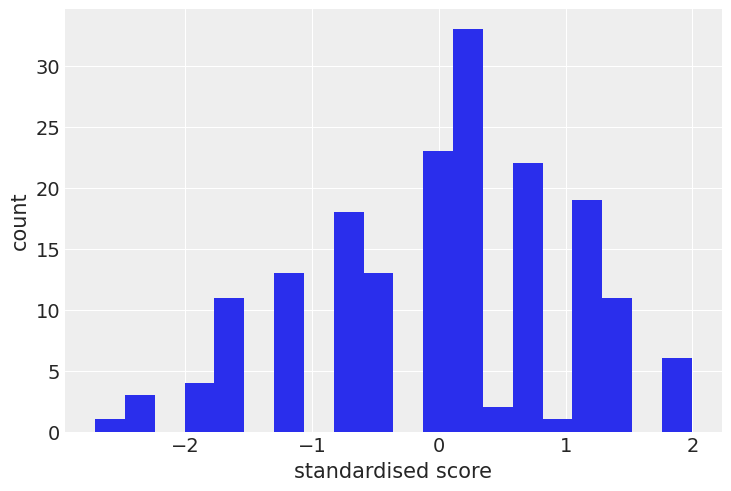

In [6]:
plt.hist(df['score'].values, bins=20)
plt.xlabel('standardised score')
plt.ylabel('count')
plt.show()

In [7]:
df1 = df.loc[:, ['judge', 'wine', 'score']]
df1.head()

,judge,wine,score
0,Jean-M Cardebat,A1,-1.581002
1,Jean-M Cardebat,B1,-0.451715
2,Jean-M Cardebat,C1,-0.075286
3,Jean-M Cardebat,D1,0.301143
4,Jean-M Cardebat,E1,-2.333860


In [8]:
# transform the judge and wine variables into index variables
judges = df1.judge.unique()
wines = df1.wine.unique()

from sklearn.preprocessing import LabelEncoder

judge_encoder = LabelEncoder()
wine_encoder = LabelEncoder()

judge_encoder.fit(df1['judge'])
wine_encoder.fit(df1['wine'])

df1['judge'] = judge_encoder.transform(df1['judge'])
df1['wine'] = wine_encoder.transform(df1['wine'])

df1.head()

,judge,wine,score
0,3,0,-1.581002
1,3,2,-0.451715
2,3,4,-0.075286
3,3,6,0.301143
4,3,8,-2.333860


In [9]:
df1

,judge,wine,score
0,3,0,-1.581002
1,3,2,-0.451715
2,3,4,-0.075286
3,3,6,0.301143
4,3,8,-2.333860
...,...,...,...
175,1,11,-0.828144
176,1,13,0.301143
177,1,15,0.677572
178,1,17,-2.710289


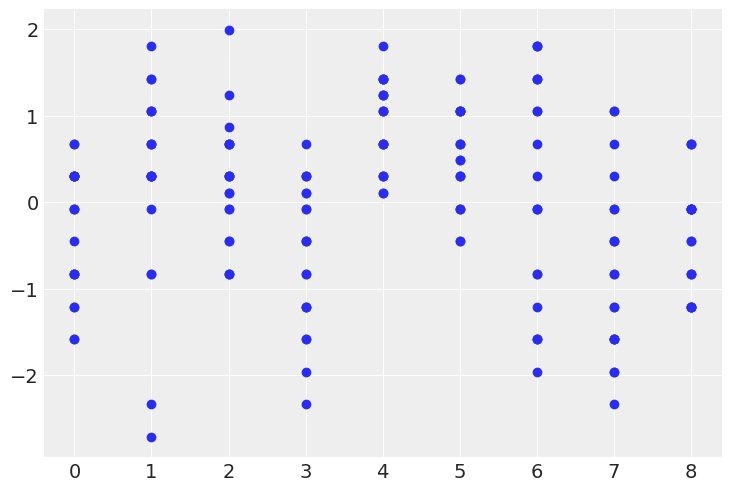

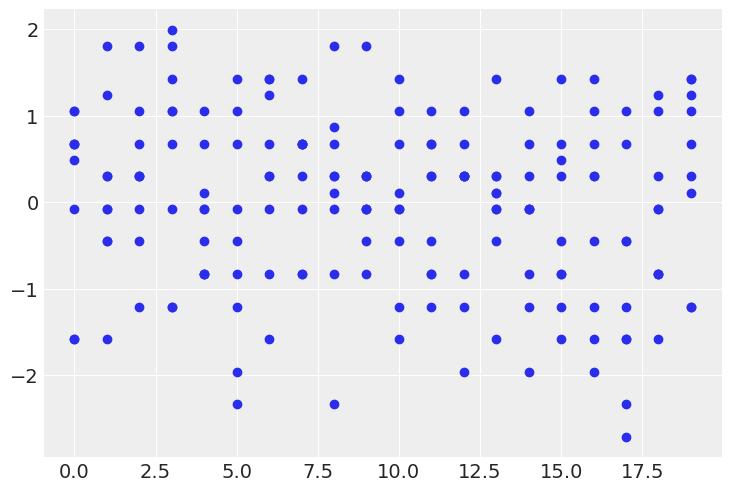

In [10]:
plt.scatter(df1.judge, df1.score)
plt.show()
plt.scatter(df1.wine, df1.score)
plt.show()

In [11]:
def model_1(judge=None, wine=None, score=None):
    # priors
    # alpha = numpyro.sample("alpha", dist.Normal(0,0.5)))
    beta_j = numpyro.sample("beta_judge", dist.Normal(0, 0.5).expand([len(judges)]))
    beta_w = numpyro.sample("beta_wine", dist.Normal(0, 0.5).expand([len(wines)]))
    sigma = numpyro.sample("sigma", dist.InverseGamma(1))
    # deterministic
    mu = numpyro.deterministic("mu", beta_j[judge] + beta_w[wine])
    # likelihood
    numpyro.sample("score", dist.Normal(mu, sigma), obs=score) 

## code taken from https://fehiepsi.github.io/rethinking-numpyro/05-the-many-variables-and-the-spurious-waffles.html 5.54

### TODO: prior predictive check

In [12]:
nuts_kernel = numpyro.infer.NUTS(model_1)

mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=4, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, judge=df1.judge.values, wine=df1.wine.values, score=df1.score.values)

posterior_samples_1 = mcmc.get_samples()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [13]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
beta_judge[0]     -0.28      0.20     -0.28     -0.59      0.05   5059.48      1.00
beta_judge[1]      0.21      0.20      0.21     -0.10      0.54   5903.22      1.00
beta_judge[2]      0.21      0.19      0.21     -0.13      0.51   5889.09      1.00
beta_judge[3]     -0.54      0.20     -0.55     -0.85     -0.21   6096.08      1.00
beta_judge[4]      0.80      0.20      0.80      0.46      1.11   6098.93      1.00
beta_judge[5]      0.48      0.20      0.48      0.15      0.79   5795.22      1.00
beta_judge[6]      0.13      0.19      0.13     -0.16      0.46   5390.60      1.00
beta_judge[7]     -0.66      0.20     -0.66     -0.97     -0.34   6374.98      1.00
beta_judge[8]     -0.35      0.20     -0.35     -0.68     -0.03   5935.03      1.00
 beta_wine[0]      0.12      0.26      0.12     -0.31      0.55   7754.97      1.00
 beta_wine[1]      0.09      0.26      0.09     -0.31      0.53   8855.61  

Text(0.5, 1.0, '94% HDI, judges')

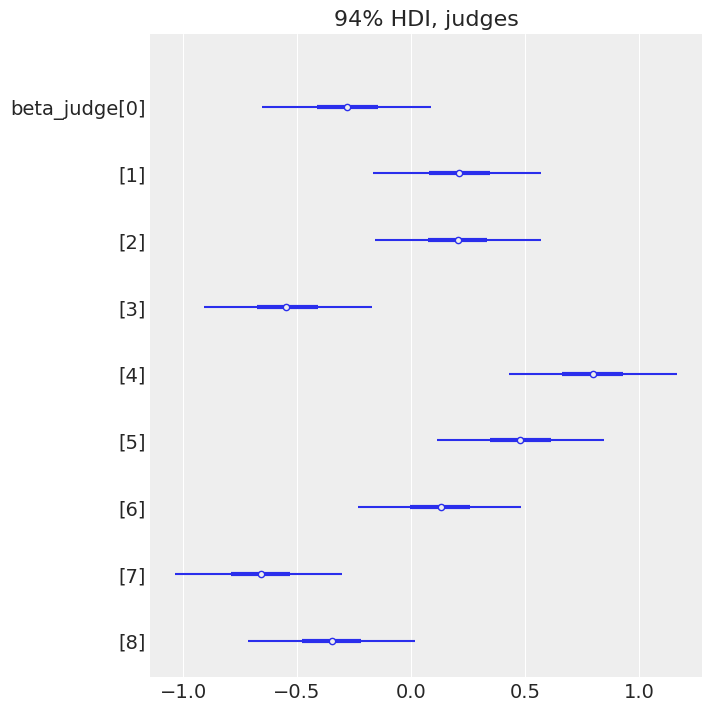

In [14]:
data_1 = az.from_numpyro(mcmc)
az.plot_forest(data_1, kind='forestplot', var_names=["beta_judge"], combined=True, figsize=(7, 7));
plt.title('94% HDI, judges')

Text(0.5, 1.0, '94% HDI, wines')

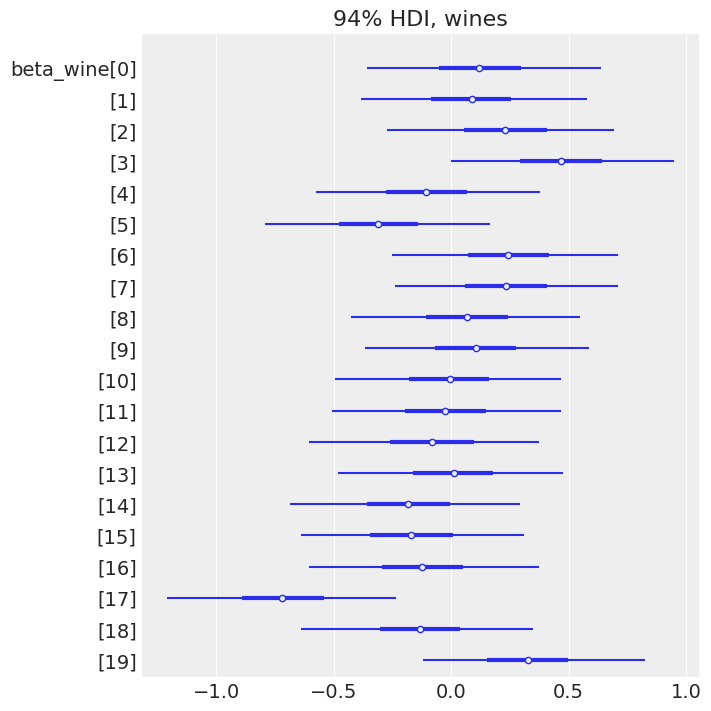

In [15]:
az.plot_forest(data_1, kind='forestplot', var_names=["beta_wine"], combined=True, figsize=(7, 7));
plt.title('94% HDI, wines')

So a lot of variation between the judges, not so much between the wines.

## Exercise 2

Now consider three features of the wines and judges:
	
flight: Whether the wine is red or white.
		
wine.amer: Indicator variable for American wines.
		
judge.amer: Indicator variable for American judges.

Use indicator or index variables to model the influence of these features on the scores. Omit the individual judge and wine index                         variables from Problem. Do not include interaction effects yet. Again use ulam, justify your priors, and be sure to check the chains. What do you conclude about the differences among the wines and judges? Try to relate the results to the inferences in Problem 1.

In [16]:
df.head()

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,-1.581002,1,0
1,Jean-M Cardebat,white,B1,-0.451715,1,0
2,Jean-M Cardebat,white,C1,-0.075286,0,0
3,Jean-M Cardebat,white,D1,0.301143,0,0
4,Jean-M Cardebat,white,E1,-2.333860,1,0


In [46]:
print(df['flight'].unique())


['white' 'red']


In [18]:
df2 = df.loc[:, ['flight', 'score', 'wine.amer', 'judge.amer']]
df2.replace('red', 1, inplace=True)
df2.replace('white', 0, inplace=True)
print(df2['flight'].unique())
print(df2['wine.amer'].unique())
print(df2['judge.amer'].unique())

df2.head()

[0 1]
[1 0]
[0 1]


,flight,score,wine.amer,judge.amer
0,0,-1.581002,1,0
1,0,-0.451715,1,0
2,0,-0.075286,0,0
3,0,0.301143,0,0
4,0,-2.333860,1,0


In [35]:
def model_2(red=None, wine_amer=None, judge_amer=None, score=None):
    # priors
    alpha = numpyro.sample("alpha", dist.Normal(0,0.5))
    beta_red = numpyro.sample("beta_red", dist.Normal(0, 0.5))
    beta_ja = numpyro.sample("beta_judge_am", dist.Normal(0, 0.5))
    beta_wa = numpyro.sample("beta_wine_am", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.InverseGamma(1))
    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta_red * red + beta_ja * judge_amer + beta_wa*wine_amer)
    # likelihood
    numpyro.sample("score", dist.Normal(mu, sigma), obs=score) 


In [36]:
nuts_kernel = numpyro.infer.NUTS(model_2)

mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=4, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, red=df2.flight.values , judge_amer=df2['judge.amer'].values, wine_amer=df2['wine.amer'].values, score=df2.score.values)

posterior_samples_2 = mcmc.get_samples()

mcmc.print_summary()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          alpha     -0.02      0.15     -0.01     -0.27      0.22   5254.96      1.00
  beta_judge_am      0.23      0.14      0.23      0.00      0.46   6298.24      1.00
       beta_red     -0.01      0.14     -0.01     -0.25      0.22   6686.66      1.00
   beta_wine_am     -0.18      0.14     -0.18     -0.40      0.07   6154.72      1.00
          sigma      1.00      0.05      1.00      0.91      1.09   6950.88      1.00

Number of divergences: 0


Text(0.5, 1.0, '94% HDI')

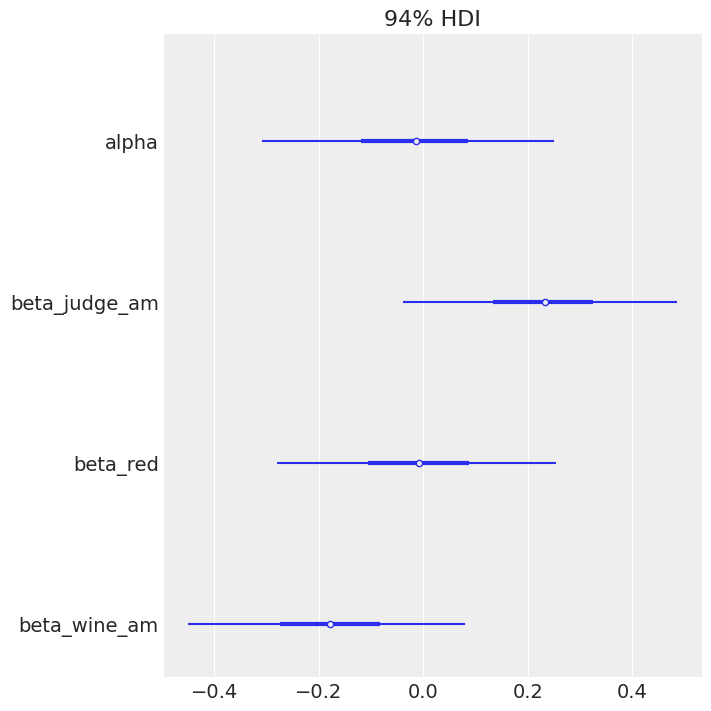

In [39]:
data_2 = az.from_numpyro(mcmc)
az.plot_forest(data_2, kind='forestplot', var_names=['~mu', '~sigma'], combined=True, figsize=(7,7));
plt.title('94% HDI')

Outcomes:

1.   judge: american judges score slightly higher

2.   red: red or white doesn't affect the score

3.   wine: american wine worse than others



## Exercise 3

Now consider two-way interactions among the three features. You should end up with three different interaction terms in your model.  These will be easier to build, if you use indicator variables. Again use ulam, justify your priors, and be sure to check the chains. Explain what each interaction means. Be sure to interpret the model’s predictions on the outcome scale (mu, the expected score), not on the scale of individual parameters. You can use link to help with this, or just use your knowledge of the linear model instead.
 
What do you conclude about the features and the scores? Can you relate the results of your model(s) to the individual judge and wine               inferences from Problem 1?

In [40]:
df3 = df2.copy()

In [43]:
def model_3(red=None, wine_amer=None, judge_amer=None, score=None):

    # priors
    alpha = numpyro.sample("alpha", dist.Normal(0,0.5))
    beta_red = numpyro.sample("beta_red", dist.Normal(0, 0.5))
    beta_ja = numpyro.sample("beta_judge_am", dist.Normal(0, 0.5))
    beta_wa = numpyro.sample("beta_wine_am", dist.Normal(0, 0.5))

    # interactions
    beta_red_ja = numpyro.sample("beta_red_judge", dist.Normal(0, 0.5))
    beta_red_wa = numpyro.sample("beta_red_wine", dist.Normal(0, 0.5))
    beta_ja_wa = numpyro.sample("beta_judge_wine", dist.Normal(0, 0.5))


    sigma = numpyro.sample("sigma", dist.InverseGamma(1))
    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta_red * red + beta_ja * judge_amer + beta_wa*wine_amer + beta_red_ja*red*judge_amer + beta_red_wa*red*wine_amer + beta_ja_wa*wine_amer*judge_amer)
    # likelihood
    numpyro.sample("score", dist.Normal(mu, sigma), obs=score) 


In [44]:
nuts_kernel = numpyro.infer.NUTS(model_3)

mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=4, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, red=df3.flight.values , judge_amer=df3['judge.amer'].values, wine_amer=df3['wine.amer'].values, score=df3.score.values)

posterior_samples_3 = mcmc.get_samples()

mcmc.print_summary()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
            alpha     -0.10      0.17     -0.10     -0.40      0.16   3943.86      1.00
    beta_judge_am      0.21      0.21      0.21     -0.12      0.58   4378.20      1.00
  beta_judge_wine     -0.04      0.24     -0.04     -0.41      0.37   4909.25      1.00
         beta_red      0.17      0.22      0.17     -0.19      0.53   4551.67      1.00
   beta_red_judge      0.08      0.24      0.08     -0.34      0.46   5267.47      1.00
    beta_red_wine     -0.39      0.24     -0.40     -0.80     -0.01   5000.63      1.00
     beta_wine_am      0.02      0.21      0.02     -0.33      0.36   4371.62      1.00
            sigma      1.00      0.05      1.00      0.92      1.09   7346.31      1.00

Number of divergences: 0


Text(0.5, 1.0, '94% HDI')

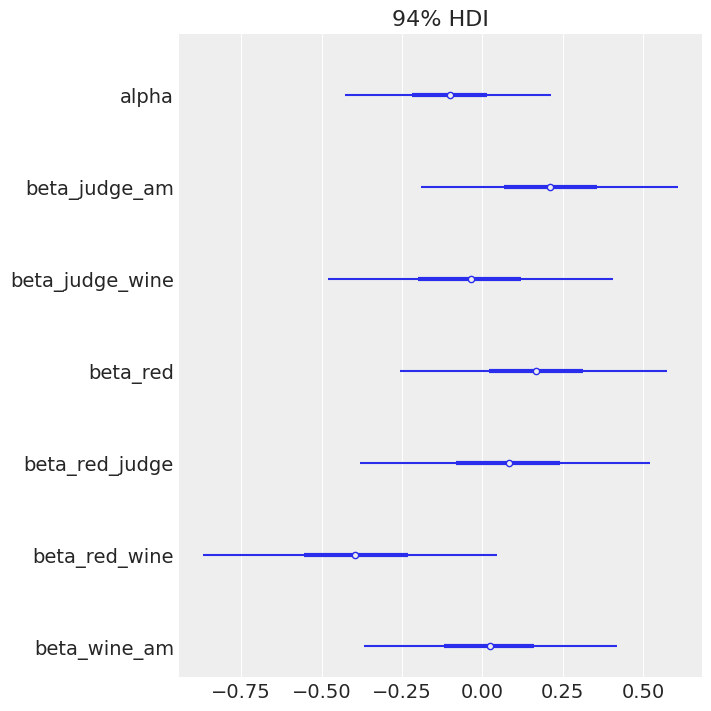

In [45]:
data_3 = az.from_numpyro(mcmc)
az.plot_forest(data_3, kind='forestplot', var_names=['~mu', '~sigma'], combined=True, figsize=(7,7));
plt.title('94% HDI')

Conclusions:



1.   Red american wines were scored lower

2.   American wines no longer worse than others




